In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Cart Pole
CartPole is a classic control problem. The agent controls a cart moving along a frictionless track. The cart can move left or right. The agent must apply a force of +1 or -1 to the cart. The agent is rewarded for every time step the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

![](cartpole.png)
https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [119]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('threshold: ', env.spec.reward_threshold)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
threshold:  195.0


# Reinforce Algorithm
Pseudocode:

![](pg_pseudocode.png)

In [133]:
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
HIDDEN_SIZE = 256

# Line 2 of the pseudocode
model = torch.nn.Sequential(
    torch.nn.Linear(obs_size, HIDDEN_SIZE),
    torch.nn.ReLU(),
    torch.nn.Linear(HIDDEN_SIZE, n_actions),
    torch.nn.Softmax(dim=-1)
)

print(model)

learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.99
score = [] # Keep track of the trajectory length over training time

# Line 3 of the pseudocode
for trajectory in range(MAX_TRAJECTORIES):
    curr_state = env.reset()
    done = False
    transitions = [] # List of (state, action, reward) tuples - transactions of the current trajectory

    # Line 4: Run the agent for one episode
    for t in range(Horizon):
        act_prob = model(torch.from_numpy(curr_state).float()) # Get action probabilities by passing the state to the model
        action = np.random.choice(np.array([0, 1]), p=act_prob.detach().numpy()) # Sample an action
        prev_state = curr_state # Save the current state
        curr_state, _, done, info = env.step(action) # Take an action
        transitions.append((prev_state, action, t+1)) # Save the transition
        # The agent is rewarded 1 (t+1) for every time step the pole remains upright
        if done:
            break
    score.append(len(transitions)) # Save the reward
    reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,)) # Get the rewards

    batch_Gvals = []
    # Line 5: Compute the expected return for each transaction
    for i in range(len(transitions)):
        new_Gval = 0
        power = 0
        # Line 6: Compute the return
        for j in range(i, len(transitions)):
            # G_t = r_(t+1) + r_(t+2) + ...
            new_Gval = new_Gval + ((gamma**power) * reward_batch[j]).numpy() # Compute the discounted reward
            power += 1
        batch_Gvals.append(new_Gval)
    # Stores the expected returns for all the transactions of the current trajectory
    expected_returns_batch = torch.FloatTensor(batch_Gvals)
    # Normalizes the rewards to be within the [0,1] interval to improve numerical stability.
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s, a, r) in transitions])
    action_batch = torch.LongTensor([a for (s, a, r) in transitions])

    """
    Recompute the action probabilities for all the states in the trajectory and subsets
    the action probabilities associated with the actions that were actually taken
    """
    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1, 1)).squeeze()

    # Line 7: Compute the loss
    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch)

    # Line 8: PyTorch prefers gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0:
        print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=-1)
)
Trajectory 0	Average Score: nan
Trajectory 50	Average Score: 42.47
Trajectory 100	Average Score: 87.51
Trajectory 150	Average Score: 102.73
Trajectory 200	Average Score: 186.82
Trajectory 250	Average Score: 141.76
Trajectory 300	Average Score: 102.35
Trajectory 350	Average Score: 164.63
Trajectory 400	Average Score: 198.27
Trajectory 450	Average Score: 122.31


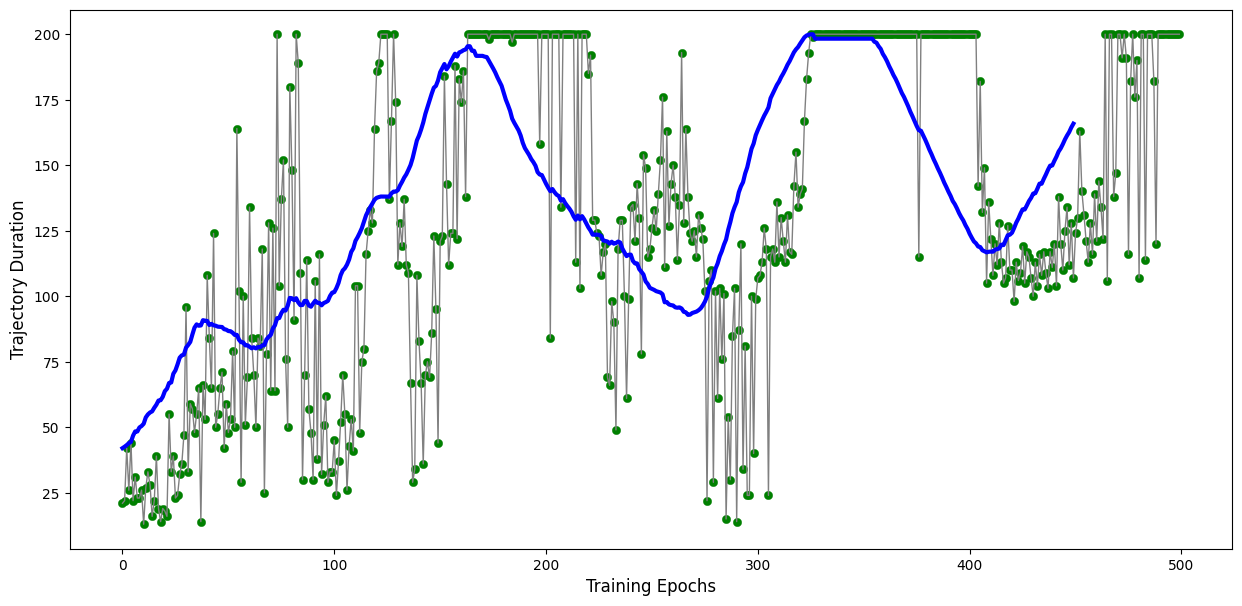

In [134]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

Reward: 200.0


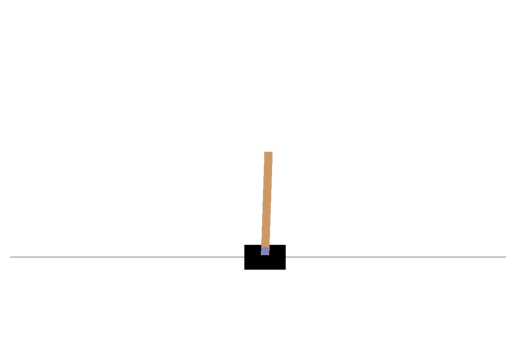

In [135]:
def watch_agent():
  env = gym.make('CartPole-v0')
  state = env.reset()
  rewards = []
  img = plt.imshow(env.render(mode='rgb_array'))
  for t in range(2000):
    pred = model(torch.from_numpy(state).float())
    action = np.random.choice(np.array([0,1]), p=pred.data.numpy())

    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    # display.display(plt.gcf())
    # display.clear_output(wait=True)

    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        print("Reward:", sum([r for r in rewards]))
        break
  env.close()

watch_agent()


# References
- https://www.sefidian.com/2021/10/01/policy-g/#:~:text=Policy%20gradients%20is%20a%20family,Learning%20Atari%20games%20by%20DeepMind.
- https://huggingface.co/deep-rl-course/unit4/hands-on?fw=pt